In [19]:
import json
from collections import Counter
import pandas as pd

In [20]:
from py2neo import Node, Relationship, Graph
from tqdm import tqdm

## Preconfiguring db access and clearing existing database

In [18]:
credentials = {
    'host': 'bolt://openie.gpu.computer:7687',
    'username': 'neo4j',
    'password': 'openinfoextract'
}

In [19]:
graph: Graph = Graph(credentials['host'], auth=(credentials['username'], credentials['password']))

In [73]:
def nuke_database():
    graph.run("MATCH (n) DETACH DELETE n")

In [74]:
nuke_database()

In [21]:
with open("./data/clusters_annotation.json", 'r') as f:
    annots = json.load(f)

In [29]:
examples = {rel['rel_type']:rel['qa_examples'] for rel in annots.values()}

In [32]:
examples = {k:v for k, v in examples.items() if len(v) > 0}

In [34]:
examples.keys()

dict_keys(['awards', 'birth', 'propositions', 'heads', 'membership', 'degree_receiving', 'writing', 'introducing', 'publishing', 'launch', 'join', 'acquire', 'who_is', 'ceo_at', 'known_as', 'developed', 'professor_at', 'form', 'left', 'support', 'death_critics', 'founder', 'based', 'sentenced', 'appear', 'grow_up_in', 'director', 'invented', 'headquartered', 'subsidiary', 'released'])

In [42]:
existing = [cluster_annot[int(k)] for k in common_keys]

In [44]:
set(examples.keys()) & set(existing)

{'developed', 'known_as', 'released', 'subsidiary'}

## Reading clusters and getting rid of unannotated clusters(optional)

In [36]:
with open("./data/dcec_gmm_50c_001.json", 'r', encoding='utf-8') as f:
    cluster_triplets = json.load(f)

In [37]:
cluster_annot = {
 7: "present",
 9: "developed",
 11: "member",
 13: "lawsuit",
 14: "graduate",
 17: "where_aducated",
 23: "wrote",
 24: "family",
 25: "removed",
 26: "known_as",
 29: "formed",
 30: "serve",
 31: "directed",
 32: "brought",
 33: "who_met_whom",
 35: "ceased",
 36: "launched",
 37: "gained_smth",
 38: "born",
 39: "invent",
 40: "subsidiary",
 41: "grew_up",
 43: "conceived",
 46: "released",
 48: "issued",
 49: "died/buried"
 }

In [38]:
len(cluster_annot.keys()), len(cluster_triplets.keys())

(26, 49)

In [39]:
common_keys = set(cluster_triplets.keys()).intersection(set(map(str, cluster_annot.keys())))

In [40]:
#mapping keys from str -> int, then sorting them, then mapping back int -> str
common_keys = list(
    map(str, sorted(
        list(map(int, common_keys))
    ))
)

## Separating mapping into triplets and their predicates

In [63]:
cluster2predicates = {}
triplets = []
for key in tqdm(common_keys):
    
    cluster = cluster_triplets[key]
    predicates = list(cluster['predicates'].keys())
    rel_type = cluster_annot[int(key)]
    cluster2predicates[rel_type] = predicates
    
    for triplet in cluster['data']:
        reformatted_triplet = {
            'subject': triplet[0],# who/what is acting
            'object': triplet[2], # who/what is a target/part of action
            'prob': triplet[3], 
            'rel_type': rel_type
        }
        triplets.append(reformatted_triplet)

In [85]:
def triplet_representation(triplet):
    return f"({triplet['subject']})-[{triplet['rel_type']}]->({triplet['object']}) <=> |{triplet['prob']:.4f}|" 

## Some stats

In [65]:
print(f"Total num of triplets: {len(triplets)}")

Total num of triplets: 9967


In [66]:
Counter(map(triplet_representation, triplets)).most_common(10)

[('(Standards)-[graduate]->(NIST)', 13),
 ('(Renegades)-[where_aducated]->(Command Center)', 6),
 ('(Ottobock)-[family]->(2005)', 6),
 ('(Ottobock)-[family]->(International Paralympic Committee)', 6),
 ('(Holmes)-[family]->(2014)', 6),
 ('(Samsung)-[ceased]->(11 October)', 6),
 ('(Tim Berners-Lee)-[family]->(World Wide Web)', 5),
 ('(SAP)-[released]->(SAP)', 5),
 ('(Dunya School)-[developed]->(IB Diploma Program)', 4),
 ('(App Store)-[developed]->(Apple)', 4)]

In [67]:
print(f"Num of uniq triplets: {len(set(map(triplet_representation, triplets)))}")

Num of uniq triplets: 8969


In [68]:
import seaborn as sns

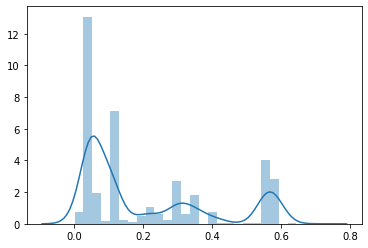

In [69]:
sns.distplot([trip['prob'] for trip in triplets])

## Removing duplicates

In [70]:
triplets = list(
    map(json.loads, set( # removing duplicates and mapping back to python dicts
        map(json.dumps, triplets)) # mapping into hashable type: str
    )
)

## Inserting into database (in object-relation-object structure)

In [76]:
object_mapping = {}

for subject in set(obj['subject'] for obj in triplets):
    object_mapping[subject] = Node('object', name=subject)
    #graph.create(subject_mapping[subject])
    
for obj in set(obj['object'] for obj in triplets):
    if obj not in object_mapping.keys():
        object_mapping[obj] = Node('object', name=obj)
    #graph.create(object_mapping[obj])
    
for obj in tqdm(triplets):
    
    object_node = object_mapping[obj['object']]
    subject_node = object_mapping[obj['subject']]
    #print(object_node)
    
    relation_type = obj['rel_type']
    relationship = Relationship.type("predicate")
    rel = relationship(subject_node, object_node, type=relation_type, prob=obj['prob'])
    
    graph.create(rel)

100%|██████████| 9484/9484 [03:01<00:00, 52.22it/s]


## That is how to perform queries

In [86]:
def query(subject_name = None, relation_type = None, object_name = None, verbose=False):
    """
    At least two arguments should not be None for adequate amount of results
    """
    query = "MATCH (s:object)-[r:predicate]->(o:object) [WHERE_CLAUSE]RETURN s.name as subject, r.type as rel_type, r.prob as prob, o.name as object"
    
    clause = "WHERE "
    used = False
    if subject_name is not None:
        clause += f"s.name = '{subject_name}' "
        used = True
    if relation_type is not None:
        clause_item = f"r.type = '{relation_type}' "
        if used:
            clause_item = "AND " + clause_item
            
        clause += clause_item
        used = True
    if object_name is not None:
        clause_item = f"o.name = '{object_name}' "
        if used:
            clause_item = "AND " + clause_item
            
        clause += clause_item
        used = True
        
    if used:
        query = query.replace("[WHERE_CLAUSE]", clause)
    else:
        query = query.replace("[WHERE_CLAUSE]", '')
        
    if verbose:
        print(query)
        
    return list(map(triplet_representation, graph.run(query).to_data_frame().to_dict(orient='records')))

In [87]:
query(subject_name='Google')

['(Google)-[developed]->(NSS) <=> |0.5572|',
 '(Google)-[family]->(BigBlueButton) <=> |0.0476|',
 '(Google)-[developed]->(Google Docs) <=> |0.5572|',
 '(Google)-[where_aducated]->(29 September 2010) <=> |0.1047|',
 '(Google)-[family]->(July 2006) <=> |0.0476|',
 '(Google)-[developed]->(March 2014) <=> |0.5572|',
 '(Google)-[subsidiary]->(October 2016) <=> |0.1049|',
 '(Google)-[subsidiary]->(Ireland) <=> |0.0509|',
 '(Google)-[formed]->(Alphabet Inc.) <=> |0.3538|',
 '(Google)-[developed]->(October 2014) <=> |0.5572|',
 '(Google)-[where_aducated]->(October 2013) <=> |0.1047|',
 '(Google)-[where_aducated]->(June 2015) <=> |0.1045|',
 '(Google)-[where_aducated]->(July 1) <=> |0.1045|',
 '(Google)-[developed]->(Group Plan) <=> |0.5572|',
 '(Google)-[subsidiary]->(2016) <=> |0.0512|',
 '(Google)-[released]->(July 2017) <=> |0.5847|',
 '(Google)-[family]->(May 2013) <=> |0.0476|',
 '(Google)-[released]->(ARC Welder) <=> |0.5847|',
 '(Google)-[brought]->(Africa) <=> |0.2466|',
 '(Google)-[la

In [88]:
relations_str = json.dumps(cluster2predicates)

In [101]:
with open("./relations.txt", 'w', encoding='utf-8') as f:
    f.write(relations_str)

## Writing stuff for api

In [102]:
%%writefile qa_service.py

from bentoml import BentoService, api, env, artifacts
from bentoml.artifact import TextFileArtifact
from bentoml.handlers import JsonHandler

import flair
from flair.data import Sentence
from flair.models import SequenceTagger

from py2neo import Graph

import json

import pandas as pd

@env(pip_dependencies=['flair', 'torch', 'pandas', 'py2neo', 'numpy'])
@artifacts([TextFileArtifact('relations')])
class QAService(BentoService):
    
    def get_entities(self, the_question, model):
        the_sentenced_question = Sentence(the_question)
        model.predict(the_sentenced_question)
        spans = [span for span in the_sentenced_question.get_spans('ner') if span.tag == "PER" or span.tag == "MISC" or span.tag == 'LOC']
        entities = [" ".join([tok.text for tok in span.tokens]) for span in spans]
        return entities
    
    def query(self, graph, subject_name = None, relation_type = None, object_name = None):
        """
        At least two arguments should not be None for adequate amount of results
        """
        query = "MATCH (s:object)-[r:predicate]->(o:object) [WHERE_CLAUSE]RETURN s.name as subject, r.type as relation, r.prob as prob, o.name as object"

        clause = "WHERE "
        used = False
        if subject_name is not None:
            clause += f"s.name = '{subject_name}' "
            used = True
        if relation_type is not None:
            clause_item = f"r.type = '{relation_type}' "
            if used:
                clause_item = "AND " + clause_item

            clause += clause_item
            used = True
        if object_name is not None:
            clause_item = f"o.name = '{object_name}' "
            if used:
                clause_item = "AND " + clause_item

            clause += clause_item
            used = True

        if used:
            query = query.replace("[WHERE_CLAUSE]", clause)
        else:
            query = query.replace("[WHERE_CLAUSE]", '')

        return graph.run(query).to_data_frame()
    
    def execute_question(self, question, ner_model, relations, graph):
        ##--stage 1: detect entities--##
        entities = self.get_entities(question, model=ner_model)

        true_relation_types = []
        ##--stage 2: detect relations--##
        for candidate_relation_type, candidate_relations_set in relations.items():
            if any(relation in question for relation in candidate_relations_set):
                true_relation_types.append(candidate_relation_type)

        ##--stage 3: executing queries--##
        dfs = []
        for entity in entities:
            for rel_type in true_relation_types:
                dfs.append(self.query(graph, subject_name=entity, relation_type=rel_type))
                dfs.append(self.query(graph, object_name=entity, relation_type=rel_type))

        return pd.concat(dfs, axis=0) if len(dfs) > 0 else []

    @api(JsonHandler)
    def predict(self, input_dict):
        
        credentials = {
            'host': 'bolt://openie.gpu.computer:7687',
            'username': 'neo4j',
            'password': 'openinfoextract'
        }
        
        ner = SequenceTagger.load('ner')
        relations = json.loads(self.artifacts.relations)
        graph = Graph(credentials['host'], auth=(credentials['username'], credentials['password']))
        question = input_dict['question']
        
        dataframe = self.execute_question(question, ner, relations, graph)
        return dataframe.to_dict(orient='records') if len(dataframe) != 0 else []
        
        

Overwriting qa_service.py


In [98]:
from qa_service import QAService

In [99]:
qa = QAService.pack(relations=relations_str)

In [100]:
qa.predict({'question': "Where Sundar Pichai is CEO at ?"})

2019-10-27 11:37:47,984 loading file /root/.flair/models/en-ner-conll03-v0.4.pt


NameError: name 'true_relation_type' is not defined

In [2]:
import json

In [12]:
with open("relations.txt") as f:
    rels = json.load(f)

In [13]:
from collections import Counter

In [14]:
superlist = []
for k in rels.keys():
    superlist += rels[k]

In [15]:
for k in rels.keys():
    rels[k] = list(filter(lambda x: not (len(x) <= 5), rels[k]))

In [17]:
with open('rels_new.txt', 'w', encoding='utf-8') as f:
    json.dump(rels, f)

In [18]:
rels

{'present': ['presented',
  'was presented in',
  'presents',
  'presented approach In',
  'was presented at',
  'presented Tor On',
  'presented idea to',
  'was presented In',
  'presented to',
  'advisor to',
  'presented paper In',
  'presented vision In',
  'presented prediction In',
  'presented In',
  "'s Advisor is",
  'philosopher at',
  'presented idea In',
  'presented scheme In',
  'was advisor From',
  'was advisor to',
  'is presented in',
  'At Advisor is',
  'proudly presented',
  'presented project at',
  'was presented during',
  'presents In',
  'Admiral of',
  'presented demos at',
  'presented results In',
  'Law of',
  'referenced by',
  'was presented with',
  'presented measurement In',
  'was present in',
  'presents version in',
  'presented functionality At',
  'presents exposition following',
  'presented talk In'],
 'developed': ['developed',
  'was developed by',
  'introduced',
  'developed by',
  'was introduced in',
  'was developed in',
  'developed in